In [1]:
import numpy as np
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.utils import to_categorical
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras import Input
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import math
import matplotlib.image as img
from PIL import Image
import pandas as pd
import cv2
 
import skimage
from skimage.transform import resize
import random
import zipfile
print(os.listdir("../input"))

# f = zipfile.ZipFile("parasitized_contrast.zip",'r')
# for file in f.namelist():
#     f.extract(file,"")
    
# f = zipfile.ZipFile("uninfected_contrast.zip",'r')
# for file in f.namelist():
#     f.extract(file,"")

Using TensorFlow backend.


['parasitized_contrast', 'uninfected_contrast']


In [2]:
# parasitized_bright = os.listdir('/Parasitized_enlarge/bright/') 
# parasitized_contrast = os.listdir('/Parasitized_enlarge/contrast/') 
# parasitized_raw = os.listdir('/Parasitized_enlarge/raw/') 
# uninfected_bright = os.listdir('/Uninfected_enlarge/bright/')
# uninfected_contrast = os.listdir('/Uninfected_enlarge/contrast/') 
# uninfected_raw = os.listdir('/Uninfected_enlarge/raw/') 
parasitized_contrast = os.listdir('../input/parasitized_contrast/parasitized_contrast/') 
uninfected_contrast = os.listdir('../input/uninfected_contrast/uninfected_contrast/')
data = []
labels = []

In [3]:

for positive_data in parasitized_contrast:
    if positive_data == "Thumbs.db":
        continue
    image = Image.open("../input/parasitized_contrast/parasitized_contrast/" + positive_data)
    image = image.resize((64, 64))
#     rotated45 = image.rotate(45)
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)

    data.append(np.array(image))
#     data.append(np.array(rotated45))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(1)
    labels.append(1)
    labels.append(1)
    labels.append(1)

for negative_data in uninfected_contrast:
    if negative_data == "Thumbs.db":
        continue
    image = Image.open("../input/uninfected_contrast/uninfected_contrast/" + negative_data)
    image = image.resize((64, 64))
#     rotated45 = image.rotate(45)
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)
    
    data.append(np.array(image))
#     data.append(np.array(rotated45))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(0)
    labels.append(0)
    labels.append(0)
    labels.append(0)

In [4]:
Data = np.array(data)
Labels = np.array(labels)

np.save('Data' , Data)
np.save('Labels' , Labels)
print('Data : {} | labels : {}'.format(Data.shape , Labels.shape))

Data : (110232, 64, 64, 3) | labels : (110232,)


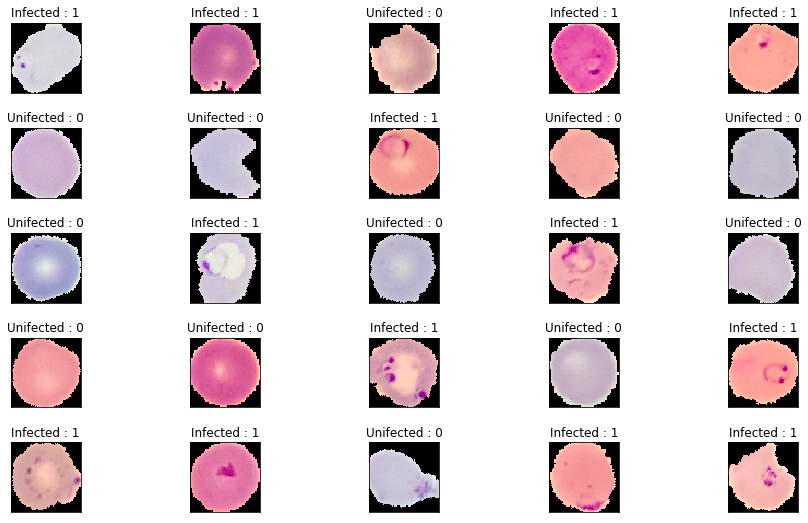

In [5]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(25):
    n += 1 
    r = np.random.randint(0 , Data.shape[0] , 1)
    plt.subplot(5 , 5 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(Data[r[0]])
    plt.title('{} : {}'.format('Infected' if Labels[r[0]] == 1 else 'Unifected' ,
                               Labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

In [6]:
from sklearn.utils import shuffle
Data, Labels = shuffle(Data, Labels)

In [7]:
Data = Data.astype(np.float32)
Data = Data / 255
Labels = Labels.astype(np.int32)

In [8]:
from sklearn.model_selection import train_test_split
ntrain = int(len(Data)*0.8)
X_test = Data[ntrain:]
y_test = Labels[ntrain:]
X_train, X_val, y_train, y_val = train_test_split(Data[0:ntrain], Labels[0:ntrain], test_size=0.2, random_state = 40)

In [9]:
print (X_train.shape)

(70548, 64, 64, 3)


In [10]:

base_model = ResNet50(include_top=False, 
                      weights='imagenet', 
                      input_shape=(64, 64, 3))
base_model.trainable = True  #Tells that all the weights are to be trained

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [11]:
model= models.Sequential()           #Creating the sequntial model
model.add(base_model)                #Adding the imagenet model
model.add(Flatten())                                #
model.add(Dense(512,activation="relu"))             #
model.add(Dropout(0.2))                             #
model.add(Dense(2,activation="softmax"))  #
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 27,783,554
Trainable params: 27,730,434
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 30, batch_size = 100)

Instructions for updating:
Use tf.cast instead.
Train on 70548 samples, validate on 17637 samples
Epoch 1/30
70548/70548 [==============================] - 101s 1ms/step - loss: 0.1491 - acc: 0.9514 - val_loss: 0.2647 - val_acc: 0.9042
Epoch 2/30
70548/70548 [==============================] - 83s 1ms/step - loss: 0.1018 - acc: 0.9654 - val_loss: 0.1644 - val_acc: 0.9467
Epoch 3/30
70548/70548 [==============================] - 83s 1ms/step - loss: 0.0919 - acc: 0.9684 - val_loss: 0.1422 - val_acc: 0.9568
Epoch 4/30
70548/70548 [==============================] - 83s 1ms/step - loss: 0.0881 - acc: 0.9697 - val_loss: 0.0925 - val_acc: 0.9684
Epoch 5/30
70548/70548 [==============================] - 84s 1ms/step - loss: 0.0801 - acc: 0.9723 - val_loss: 0.1169 - val_acc: 0.9636
Epoch 6/30
70548/70548 [==============================] - 83s 1ms/step - loss: 0.0752 - acc: 0.9734 - val_loss: 0.1058 - val_acc: 0.9650
Epoch 7/30
70548/70548 [==============================] - 83s 1ms/step - loss: 

In [15]:
accuracy = model.evaluate(X_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1], "Test loss: " , accuracy[0])

22047/22047 [==============================] - 12s 556us/step

 Test_Accuracy:- 0.9659817661861446 Test loss:  0.15371514182188364


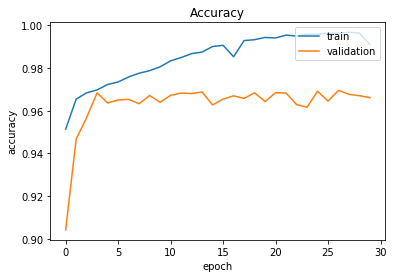

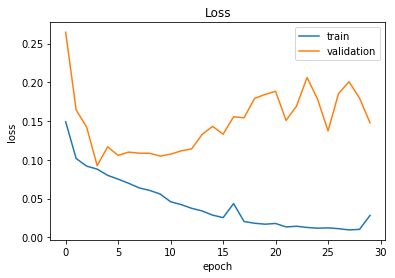

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()